# U-Net 3D CT Segmentation

This notebook implements a 3D U-Net model for segmenting pelvis from CT scans.

## Setup and Imports

First, let's check our environment and dependencies.

In [ ]:
!pip install simpleitk
!pip install medpy

# 后面再import、初始化数据集、DataLoader、训练等
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from google.colab import drive
from google.colab import files
from scipy.spatial.distance import directed_hausdorff


# Print versions for reproducibility
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"SimpleITK version: {sitk.__version__}")
print(f"NumPy version: {np.__version__}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224710 sha256=876df649d4ce943077d438312ac140e91997ab525b47626e0cc600c966384253
  Stored in directory: /root/.cache/pip/wheels/d4/33/ed/aaac5a347fb8d41679ca515b8f5c49dfdf49be15bdbb9a905d
Successfully built medpy
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB
SimpleITK version: 2.5.0
NumPy version: 2.0.2


add paths


In [ ]:
# Define paths
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/data'
BASE_DIR = '/content/drive/MyDrive/ct_segmentation'  # Create a dedicated project folder

# Create organized subdirectories
PATHS = {
    'data': f'{BASE_DIR}/data',
    'models': f'{BASE_DIR}/models',
    'checkpoints': f'{BASE_DIR}/checkpoints',
    'results': f'{BASE_DIR}/results',
    'logs': f'{BASE_DIR}/logs'
}

# Create all directories
for path in PATHS.values():
    os.makedirs(path, exist_ok=True)

# Update model save paths
MODEL_SAVE_PATH = os.path.join(PATHS['models'], 'best_unet_model.pth')
CHECKPOINT_DIR = PATHS['checkpoints']


# 1. 创建父目录
import os
os.makedirs('/content/data/images', exist_ok=True)
os.makedirs('/content/data/labels', exist_ok=True)

# 2. 解压
!unzip -q /content/drive/MyDrive/ct_segmentation/data/PENGWIN_CT_train_images.zip -d /content/data/images
!unzip -q /content/drive/MyDrive/ct_segmentation/data/PENGWIN_CT_train_labels.zip -d /content/data/labels

# 3. 用本地路径
images_path = '/content/data/images/PENGWIN_CT_train_images'
labels_path = '/content/data/labels/PENGWIN_CT_train_labels'


Mounted at /content/drive


## 3. Define network


In [ ]:
# Define the DepthwiseSeparableConv3d class first
class DepthwiseSeparableConv3d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv3d, self).__init__()
        self.depthwise = nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Define the AttentionGate class
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# Now define the UNet3D class
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                # First depthwise separable convolution
                DepthwiseSeparableConv3d(in_ch, out_ch),
                nn.BatchNorm3d(out_ch),
                nn.ReLU(inplace=True),
                # Second depthwise separable convolution
                DepthwiseSeparableConv3d(out_ch, out_ch),
                nn.BatchNorm3d(out_ch),
                nn.ReLU(inplace=True),
                # SE block for channel attention
                SEBlock(out_ch)
            )

        # Squeeze and Excitation Block for channel attention
        class SEBlock(nn.Module):
            def __init__(self, channel, reduction=16):
                super(SEBlock, self).__init__()
                self.avg_pool = nn.AdaptiveAvgPool3d(1)
                self.fc = nn.Sequential(
                    nn.Linear(channel, channel // reduction, bias=False),
                    nn.ReLU(inplace=True),
                    nn.Linear(channel // reduction, channel, bias=False),
                    nn.Sigmoid()
                )

            def forward(self, x):
                b, c, _, _, _ = x.size()
                y = self.avg_pool(x).view(b, c)
                y = self.fc(y).view(b, c, 1, 1, 1)
                return x * y.expand_as(x)

        # Encoder
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        # Attention Gates
        self.attention1 = AttentionGate(512, 512, 256)
        self.attention2 = AttentionGate(256, 256, 128)
        self.attention3 = AttentionGate(128, 128, 64)
        self.attention4 = AttentionGate(64, 64, 32)

        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose3d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.output = nn.Sequential(
            nn.Conv3d(64, out_channels, kernel_size=1),
            nn.BatchNorm3d(out_channels)
        )

        # Dropout for regularization
        self.dropout = nn.Dropout3d(p=0.3)

    def forward(self, x):
        # Encoder path with residual connections
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.dropout(self.pool(e1)))
        e3 = self.encoder3(self.dropout(self.pool(e2)))
        e4 = self.encoder4(self.dropout(self.pool(e3)))

        # Bottleneck
        b = self.bottleneck(self.dropout(self.pool(e4)))

        # Decoder path with attention and skip connections
        d4 = self.upconv4(b)
        e4 = self.attention1(d4, e4)
        d4 = self.decoder4(torch.cat((e4, d4), dim=1))

        d3 = self.upconv3(d4)
        e3 = self.attention2(d3, e3)
        d3 = self.decoder3(torch.cat((e3, d3), dim=1))

        d2 = self.upconv2(d3)
        e2 = self.attention3(d2, e2)
        d2 = self.decoder2(torch.cat((e2, d2), dim=1))

        d1 = self.upconv1(d2)
        e1 = self.attention4(d1, e1)
        d1 = self.decoder1(torch.cat((e1, d1), dim=1))

        return self.output(d1)

def print_model_summary(model):
    """Print model architecture summary"""
    print("Model Architecture:")
    print("------------------")
    total_params = 0
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        print(f"{name}: {list(param.shape)} ({param_count:,} parameters)")
    print(f"\nTotal parameters: {total_params:,}")

# Initialize model and print summary
model = UNet3D(in_channels=1, out_channels=1)
print_model_summary(model)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 4 
ACCUMULATION_STEPS = 8  
PATCH_SIZE = (128, 128, 128)
STRIDE = (26, 26, 26)

Model Architecture:
------------------
encoder1.0.depthwise.weight: [1, 1, 3, 3, 3] (27 parameters)
encoder1.0.depthwise.bias: [1] (1 parameters)
encoder1.0.pointwise.weight: [64, 1, 1, 1, 1] (64 parameters)
encoder1.0.pointwise.bias: [64] (64 parameters)
encoder1.0.bn.weight: [64] (64 parameters)
encoder1.0.bn.bias: [64] (64 parameters)
encoder1.1.weight: [64] (64 parameters)
encoder1.1.bias: [64] (64 parameters)
encoder1.3.depthwise.weight: [64, 1, 3, 3, 3] (1,728 parameters)
encoder1.3.depthwise.bias: [64] (64 parameters)
encoder1.3.pointwise.weight: [64, 64, 1, 1, 1] (4,096 parameters)
encoder1.3.pointwise.bias: [64] (64 parameters)
encoder1.3.bn.weight: [64] (64 parameters)
encoder1.3.bn.bias: [64] (64 parameters)
encoder1.4.weight: [64] (64 parameters)
encoder1.4.bias: [64] (64 parameters)
encoder1.6.fc.0.weight: [4, 64] (256 parameters)
encoder1.6.fc.2.weight: [64, 4] (256 parameters)
encoder2.0.depthwise.weight: [64, 1, 3, 3, 3] (1,728 parameters)
encoder2.0.depthwise.bias: [64

In [ ]:

# ========== 评估与可视化函数 ==========
def dice_score(pred, gt, num_classes):
    """多类别Dice，返回每个类别和平均Dice"""
    dices = []
    for c in range(1, num_classes):  # 跳过背景
        pred_c = (pred == c)
        gt_c = (gt == c)
        intersection = np.sum(pred_c & gt_c)
        denom = np.sum(pred_c) + np.sum(gt_c)
        dice = (2. * intersection) / (denom + 1e-7) if denom > 0 else np.nan
        dices.append(dice)
    return dices, np.nanmean(dices)

def iou_score(pred, gt, num_classes):
    """多类别IoU，返回每个类别和平均IoU"""
    ious = []
    for c in range(1, num_classes):
        pred_c = (pred == c)
        gt_c = (gt == c)
        intersection = np.sum(pred_c & gt_c)
        union = np.sum(pred_c | gt_c)
        iou = intersection / (union + 1e-7) if union > 0 else np.nan
        ious.append(iou)
    return ious, np.nanmean(ious)

def hd95(pred, gt, spacing=(1,1,1), num_classes=4):
    """多类别HD95，返回每个类别和平均HD95"""
    try:
        from medpy.metric.binary import hd95 as medpy_hd95
    except ImportError:
        print('请先pip install medpy')
        return [np.nan]*num_classes, np.nan
    hd95s = []
    for c in range(1, num_classes):
        pred_c = (pred == c)
        gt_c = (gt == c)
        if np.sum(pred_c) == 0 or np.sum(gt_c) == 0:
            hd95s.append(np.nan)
        else:
            try:
                hd = medpy_hd95(pred_c, gt_c, voxelspacing=spacing)
            except Exception:
                hd = np.nan
            hd95s.append(hd)
    return hd95s, np.nanmean(hd95s)

def assd(pred, gt, spacing=(1,1,1), num_classes=4):
    """多类别ASSD，返回每个类别和平均ASSD"""
    try:
        from medpy.metric.binary import assd as medpy_assd
    except ImportError:
        print('请先pip install medpy')
        return [np.nan]*num_classes, np.nan
    assds = []
    for c in range(1, num_classes):
        pred_c = (pred == c)
        gt_c = (gt == c)
        if np.sum(pred_c) == 0 or np.sum(gt_c) == 0:
            assds.append(np.nan)
        else:
            try:
                a = medpy_assd(pred_c, gt_c, voxelspacing=spacing)
            except Exception:
                a = np.nan
            assds.append(a)
    return assds, np.nanmean(assds)

def plot_slice(image, label, pred, slice_idx=None, num_classes=4, save_path=None):
    """可视化单个切片的原图、标签、预测"""
    if slice_idx is None:
        slice_idx = image.shape[0] // 2
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(image[slice_idx], cmap='gray')
    plt.title('CT')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(label[slice_idx], cmap='tab20', vmin=0, vmax=num_classes-1)
    plt.title('Label')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(pred[slice_idx], cmap='tab20', vmin=0, vmax=num_classes-1)
    plt.title('Prediction')
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

def plot_three_views(image, label, pred, num_classes=4, save_path=None):
    """三视图可视化"""
    import matplotlib.pyplot as plt
    D, H, W = image.shape
    mid_d, mid_h, mid_w = D//2, H//2, W//2
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    views = ['Axial', 'Coronal', 'Sagittal']
    for i, (view, idx) in enumerate(zip(views, [mid_d, mid_h, mid_w])):
        if view == 'Axial':
            img_slice = image[idx]
            lbl_slice = label[idx]
            pred_slice = pred[idx]
        elif view == 'Coronal':
            img_slice = image[:, idx, :]
            lbl_slice = label[:, idx, :]
            pred_slice = pred[:, idx, :]
        else:
            img_slice = image[:, :, idx]
            lbl_slice = label[:, :, idx]
            pred_slice = pred[:, :, idx]
        axes[i, 0].imshow(img_slice, cmap='gray')
        axes[i, 0].set_title(f'{view} - CT')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(lbl_slice, cmap='tab20', vmin=0, vmax=num_classes-1)
        axes[i, 1].set_title(f'{view} - Label')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(pred_slice, cmap='tab20', vmin=0, vmax=num_classes-1)
        axes[i, 2].set_title(f'{view} - Prediction')
        axes[i, 2].axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

Starting fresh training for multi-class segmentation...
Number of classes: 31 (0=background, 1-10=sacrum, 11-20=left hip, 21-30=right hip)
Model parameters: 9,473,381
Using device: cuda


Epoch 1/100: 100%|██████████| 25/25 [01:02<00:00,  2.50s/it, loss=3.58, lr=0.001000]


Saved new best model with loss: 3.7079
Epoch 1/100, Loss: 3.7079, LR: 0.001000


Epoch 2/100: 100%|██████████| 25/25 [00:54<00:00,  2.18s/it, loss=3.4, lr=0.001000]


Saved new best model with loss: 3.5171
Epoch 2/100, Loss: 3.5171, LR: 0.001000


Epoch 3/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, loss=3.31, lr=0.001000]


Saved new best model with loss: 3.4061
Epoch 3/100, Loss: 3.4061, LR: 0.001000


Epoch 4/100: 100%|██████████| 25/25 [00:56<00:00,  2.28s/it, loss=3.25, lr=0.001000]


Saved new best model with loss: 3.2808
Epoch 4/100, Loss: 3.2808, LR: 0.001000


Epoch 5/100: 100%|██████████| 25/25 [00:56<00:00,  2.28s/it, loss=3.28, lr=0.001000]


Saved new best model with loss: 3.2580
Epoch 5/100, Loss: 3.2580, LR: 0.001000


Epoch 6/100: 100%|██████████| 25/25 [00:54<00:00,  2.16s/it, loss=3.21, lr=0.001000]


Saved new best model with loss: 3.2029
Epoch 6/100, Loss: 3.2029, LR: 0.001000


Epoch 7/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=3.33, lr=0.001000]


Saved new best model with loss: 3.1764
Epoch 7/100, Loss: 3.1764, LR: 0.001000


Epoch 8/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=3.1, lr=0.001000]


Saved new best model with loss: 3.1355
Epoch 8/100, Loss: 3.1355, LR: 0.001000


Epoch 9/100: 100%|██████████| 25/25 [00:57<00:00,  2.29s/it, loss=3.27, lr=0.001000]


Saved new best model with loss: 3.1181
Epoch 9/100, Loss: 3.1181, LR: 0.001000


Epoch 10/100: 100%|██████████| 25/25 [00:58<00:00,  2.34s/it, loss=2.98, lr=0.001000]


Epoch 10/100, Loss: 3.1196, LR: 0.001000


Epoch 11/100: 100%|██████████| 25/25 [00:56<00:00,  2.24s/it, loss=3.06, lr=0.001000]


Epoch 11/100, Loss: 3.1250, LR: 0.001000


Epoch 12/100: 100%|██████████| 25/25 [00:57<00:00,  2.28s/it, loss=3.09, lr=0.001000]


Saved new best model with loss: 3.0998
Epoch 12/100, Loss: 3.0998, LR: 0.001000


Epoch 13/100: 100%|██████████| 25/25 [00:55<00:00,  2.24s/it, loss=3.13, lr=0.001000]


Saved new best model with loss: 3.0545
Epoch 13/100, Loss: 3.0545, LR: 0.001000


Epoch 14/100: 100%|██████████| 25/25 [00:57<00:00,  2.31s/it, loss=3.38, lr=0.001000]


Saved new best model with loss: 3.0311
Epoch 14/100, Loss: 3.0311, LR: 0.001000


Epoch 15/100: 100%|██████████| 25/25 [00:55<00:00,  2.24s/it, loss=3.11, lr=0.001000]


Saved new best model with loss: 3.0309
Epoch 15/100, Loss: 3.0309, LR: 0.001000


Epoch 16/100: 100%|██████████| 25/25 [00:54<00:00,  2.19s/it, loss=3.05, lr=0.001000]


Saved new best model with loss: 3.0114
Epoch 16/100, Loss: 3.0114, LR: 0.001000


Epoch 17/100: 100%|██████████| 25/25 [00:54<00:00,  2.19s/it, loss=3.04, lr=0.001000]


Saved new best model with loss: 2.9928
Epoch 17/100, Loss: 2.9928, LR: 0.001000


Epoch 18/100: 100%|██████████| 25/25 [00:56<00:00,  2.27s/it, loss=3.28, lr=0.001000]


Epoch 18/100, Loss: 3.0033, LR: 0.001000


Epoch 19/100: 100%|██████████| 25/25 [00:54<00:00,  2.19s/it, loss=3.16, lr=0.001000]


Epoch 19/100, Loss: 3.0188, LR: 0.001000


Epoch 20/100: 100%|██████████| 25/25 [00:56<00:00,  2.25s/it, loss=3.11, lr=0.001000]


Saved new best model with loss: 2.9895


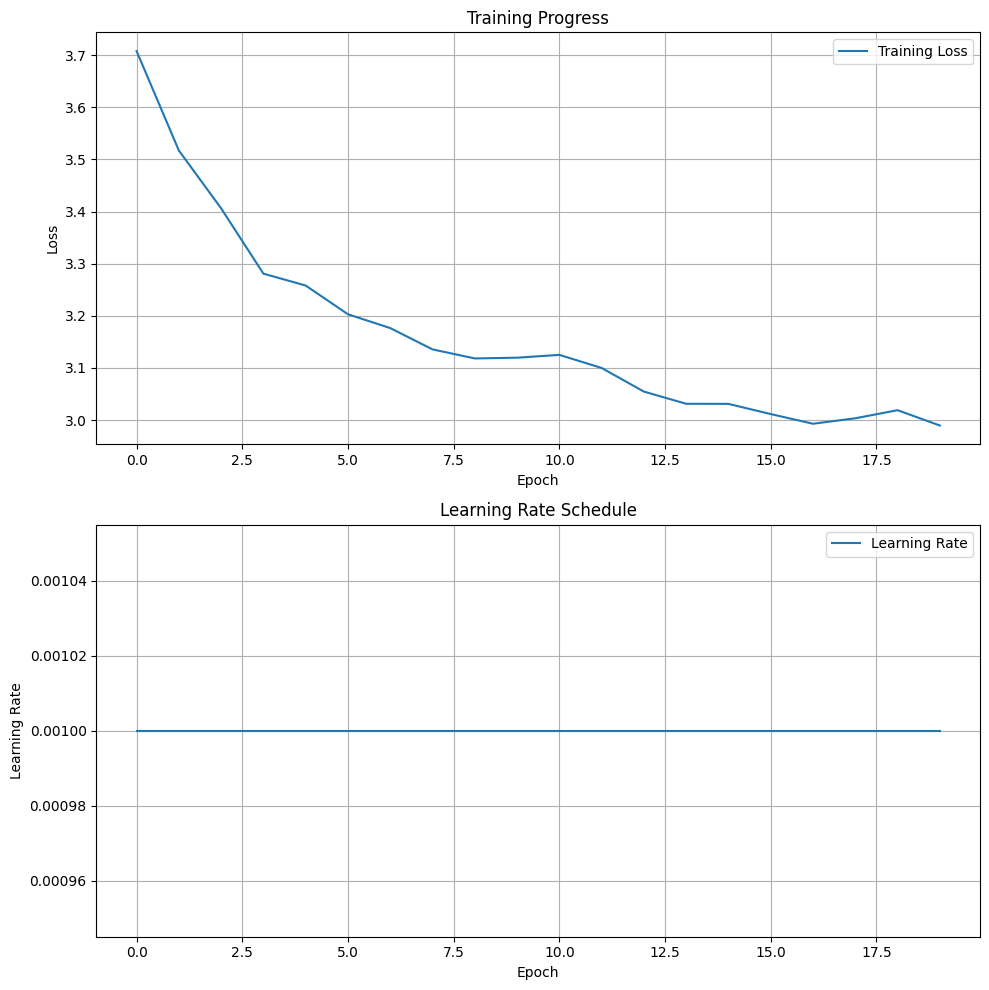

Current epoch: 20
Best loss: 2.9895
Current loss: 2.9895
Current learning rate: 0.001000
Epoch 20/100, Loss: 2.9895, LR: 0.001000


Epoch 21/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.94, lr=0.001000]


Saved new best model with loss: 2.9672
Epoch 21/100, Loss: 2.9672, LR: 0.001000


Epoch 22/100: 100%|██████████| 25/25 [00:53<00:00,  2.15s/it, loss=3.21, lr=0.001000]


Saved new best model with loss: 2.9374
Epoch 22/100, Loss: 2.9374, LR: 0.001000


Epoch 23/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=2.86, lr=0.001000]


Epoch 23/100, Loss: 2.9632, LR: 0.001000


Epoch 24/100: 100%|██████████| 25/25 [00:54<00:00,  2.19s/it, loss=2.89, lr=0.001000]


Epoch 24/100, Loss: 2.9521, LR: 0.001000


Epoch 25/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=3.21, lr=0.001000]


Saved new best model with loss: 2.9011
Epoch 25/100, Loss: 2.9011, LR: 0.001000


Epoch 26/100: 100%|██████████| 25/25 [00:56<00:00,  2.25s/it, loss=2.81, lr=0.001000]


Saved new best model with loss: 2.8896
Epoch 26/100, Loss: 2.8896, LR: 0.001000


Epoch 27/100: 100%|██████████| 25/25 [00:56<00:00,  2.26s/it, loss=2.97, lr=0.001000]


Saved new best model with loss: 2.8884
Epoch 27/100, Loss: 2.8884, LR: 0.001000


Epoch 28/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, loss=2.86, lr=0.001000]


Epoch 28/100, Loss: 2.9245, LR: 0.001000


Epoch 29/100: 100%|██████████| 25/25 [00:54<00:00,  2.20s/it, loss=2.67, lr=0.001000]


Epoch 29/100, Loss: 2.8946, LR: 0.001000


Epoch 30/100: 100%|██████████| 25/25 [00:54<00:00,  2.19s/it, loss=2.84, lr=0.001000]


Saved new best model with loss: 2.8695
Epoch 30/100, Loss: 2.8695, LR: 0.001000


Epoch 31/100: 100%|██████████| 25/25 [00:54<00:00,  2.19s/it, loss=2.89, lr=0.001000]


Saved new best model with loss: 2.8508
Epoch 31/100, Loss: 2.8508, LR: 0.001000


Epoch 32/100: 100%|██████████| 25/25 [00:56<00:00,  2.26s/it, loss=2.93, lr=0.001000]


Epoch 32/100, Loss: 2.8665, LR: 0.001000


Epoch 33/100: 100%|██████████| 25/25 [00:58<00:00,  2.34s/it, loss=2.62, lr=0.001000]


Saved new best model with loss: 2.8009
Epoch 33/100, Loss: 2.8009, LR: 0.001000


Epoch 34/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.85, lr=0.001000]


Epoch 34/100, Loss: 2.8574, LR: 0.001000


Epoch 35/100: 100%|██████████| 25/25 [00:53<00:00,  2.16s/it, loss=2.88, lr=0.001000]


Saved new best model with loss: 2.7791
Epoch 35/100, Loss: 2.7791, LR: 0.001000


Epoch 36/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.68, lr=0.001000]


Epoch 36/100, Loss: 2.8280, LR: 0.001000


Epoch 37/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=2.79, lr=0.001000]


Epoch 37/100, Loss: 2.7969, LR: 0.001000


Epoch 38/100: 100%|██████████| 25/25 [00:56<00:00,  2.28s/it, loss=2.81, lr=0.001000]


Epoch 38/100, Loss: 2.7802, LR: 0.001000


Epoch 39/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.75, lr=0.001000]


Saved new best model with loss: 2.7697
Epoch 39/100, Loss: 2.7697, LR: 0.001000


Epoch 40/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.66, lr=0.001000]


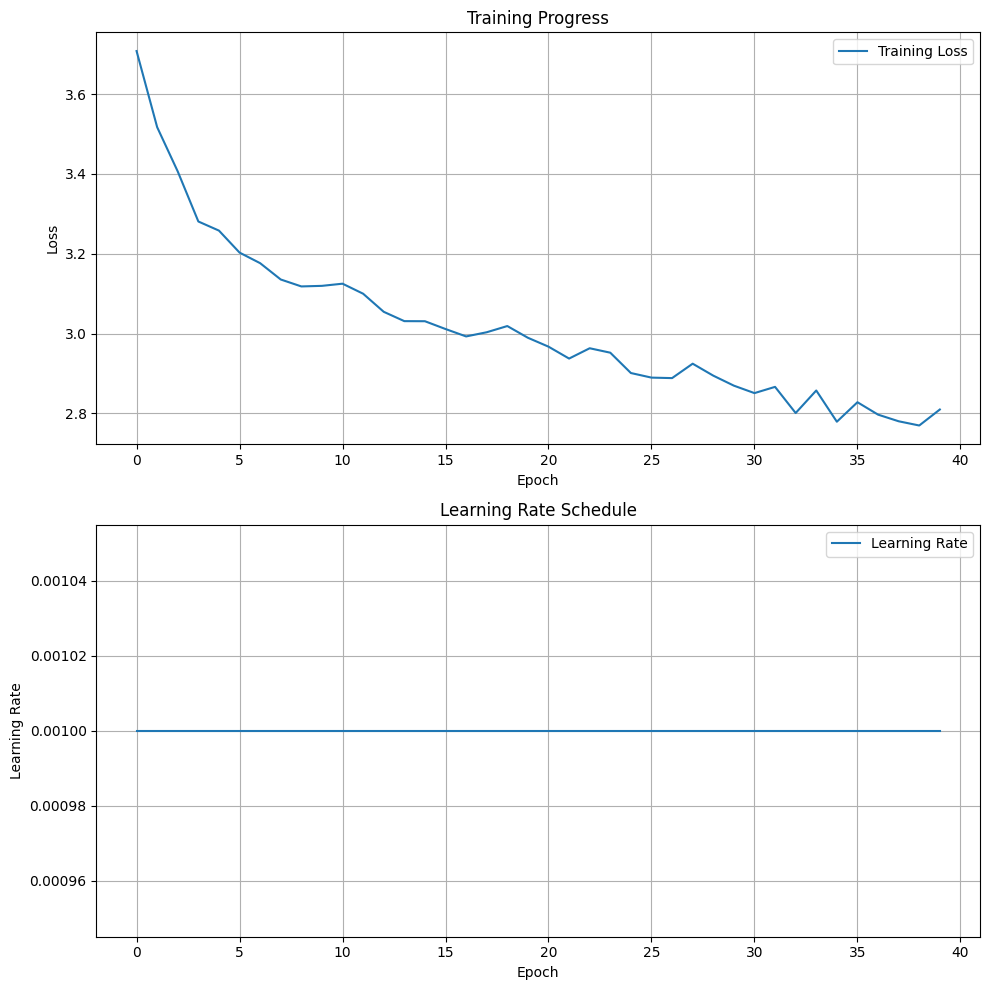

Current epoch: 40
Best loss: 2.7697
Current loss: 2.8097
Current learning rate: 0.001000
Epoch 40/100, Loss: 2.8097, LR: 0.001000


Epoch 41/100: 100%|██████████| 25/25 [00:53<00:00,  2.15s/it, loss=2.77, lr=0.001000]


Epoch 41/100, Loss: 2.7822, LR: 0.001000


Epoch 42/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.72, lr=0.001000]


Saved new best model with loss: 2.6941
Epoch 42/100, Loss: 2.6941, LR: 0.001000


Epoch 43/100: 100%|██████████| 25/25 [00:54<00:00,  2.18s/it, loss=3, lr=0.001000]


Epoch 43/100, Loss: 2.7104, LR: 0.001000


Epoch 44/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.61, lr=0.001000]


Epoch 44/100, Loss: 2.7161, LR: 0.001000


Epoch 45/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, loss=2.55, lr=0.001000]


Epoch 45/100, Loss: 2.7302, LR: 0.001000


Epoch 46/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=2.61, lr=0.001000]


Saved new best model with loss: 2.6654
Epoch 46/100, Loss: 2.6654, LR: 0.001000


Epoch 47/100: 100%|██████████| 25/25 [00:54<00:00,  2.16s/it, loss=2.8, lr=0.001000]


Epoch 47/100, Loss: 2.7663, LR: 0.001000


Epoch 48/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=2.7, lr=0.001000]


Epoch 48/100, Loss: 2.6789, LR: 0.001000


Epoch 49/100: 100%|██████████| 25/25 [00:57<00:00,  2.29s/it, loss=2.77, lr=0.001000]


Epoch 49/100, Loss: 2.7493, LR: 0.001000


Epoch 50/100: 100%|██████████| 25/25 [00:56<00:00,  2.26s/it, loss=2.73, lr=0.001000]


Validation Dice score: 0.0549
Saved new best model with Dice score: 0.0549
Epoch 50/100, Loss: 2.6927, LR: 0.001000


Epoch 51/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, loss=2.66, lr=0.000500]


Epoch 51/100, Loss: 2.6684, LR: 0.000500


Epoch 52/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, loss=2.81, lr=0.000500]


Epoch 52/100, Loss: 2.6866, LR: 0.000500


Epoch 53/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.69, lr=0.000500]


Epoch 53/100, Loss: 2.6664, LR: 0.000500


Epoch 54/100: 100%|██████████| 25/25 [00:58<00:00,  2.35s/it, loss=2.53, lr=0.000500]


Epoch 54/100, Loss: 2.6979, LR: 0.000500


Epoch 55/100: 100%|██████████| 25/25 [00:58<00:00,  2.34s/it, loss=2.77, lr=0.000250]


Epoch 55/100, Loss: 2.6802, LR: 0.000250


Epoch 56/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=2.63, lr=0.000250]


Saved new best model with loss: 2.6473
Epoch 56/100, Loss: 2.6473, LR: 0.000250


Epoch 57/100: 100%|██████████| 25/25 [00:55<00:00,  2.24s/it, loss=2.68, lr=0.000250]


Epoch 57/100, Loss: 2.6644, LR: 0.000250


Epoch 58/100: 100%|██████████| 25/25 [00:57<00:00,  2.29s/it, loss=2.62, lr=0.000250]


Saved new best model with loss: 2.6379
Epoch 58/100, Loss: 2.6379, LR: 0.000250


Epoch 59/100: 100%|██████████| 25/25 [00:57<00:00,  2.29s/it, loss=2.78, lr=0.000250]


Epoch 59/100, Loss: 2.6582, LR: 0.000250


Epoch 60/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=2.47, lr=0.000250]


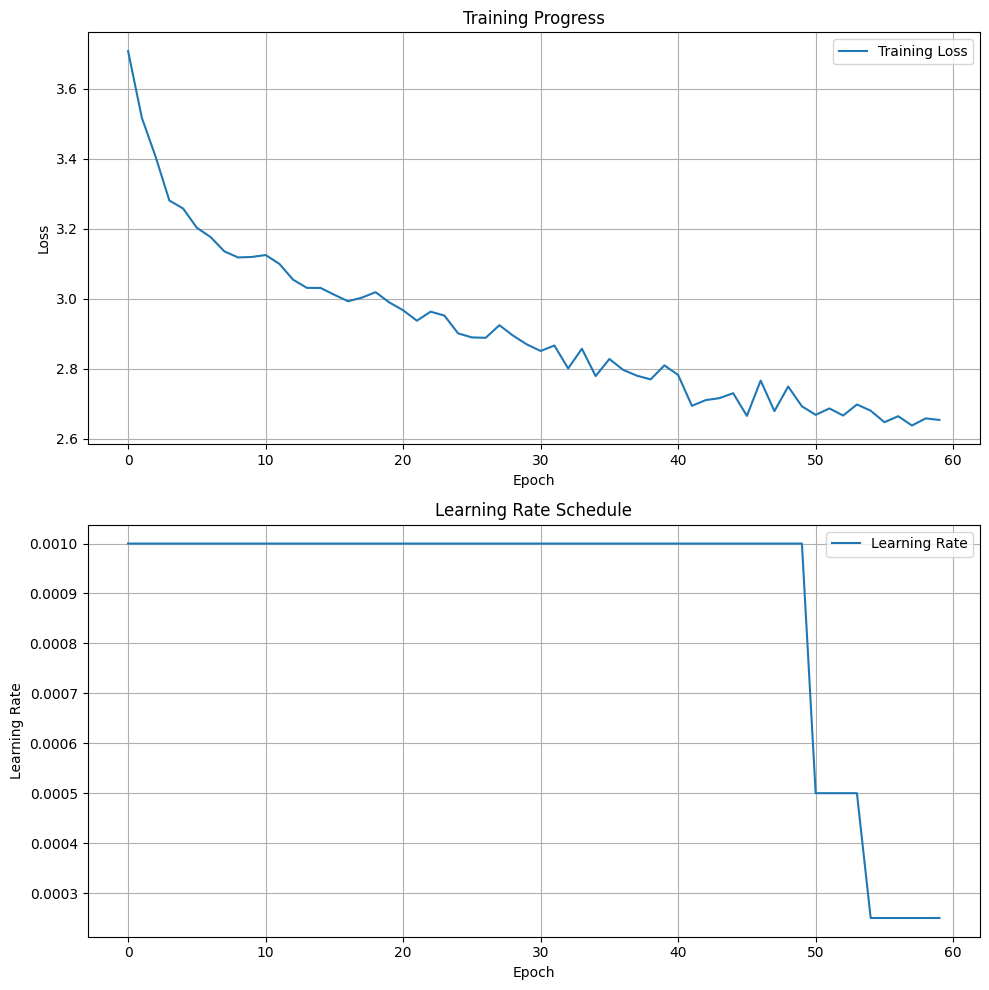

Current epoch: 60
Best loss: 2.6379
Current loss: 2.6538
Current learning rate: 0.000250
Epoch 60/100, Loss: 2.6538, LR: 0.000250


Epoch 61/100: 100%|██████████| 25/25 [00:56<00:00,  2.28s/it, loss=2.9, lr=0.000250]


Epoch 61/100, Loss: 2.6791, LR: 0.000250


Epoch 62/100: 100%|██████████| 25/25 [00:57<00:00,  2.28s/it, loss=2.47, lr=0.000250]


Epoch 62/100, Loss: 2.7234, LR: 0.000250


Epoch 63/100: 100%|██████████| 25/25 [00:59<00:00,  2.39s/it, loss=2.61, lr=0.000125]


Epoch 63/100, Loss: 2.6562, LR: 0.000125


Epoch 64/100: 100%|██████████| 25/25 [00:57<00:00,  2.30s/it, loss=2.45, lr=0.000125]


Epoch 64/100, Loss: 2.7082, LR: 0.000125


Epoch 65/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=2.74, lr=0.000125]


Saved new best model with loss: 2.6295
Epoch 65/100, Loss: 2.6295, LR: 0.000125


Epoch 66/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, loss=2.89, lr=0.000125]


Saved new best model with loss: 2.6137
Epoch 66/100, Loss: 2.6137, LR: 0.000125


Epoch 67/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=2.69, lr=0.000125]


Epoch 67/100, Loss: 2.6578, LR: 0.000125


Epoch 68/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, loss=2.58, lr=0.000125]


Epoch 68/100, Loss: 2.6245, LR: 0.000125


Epoch 69/100: 100%|██████████| 25/25 [00:55<00:00,  2.24s/it, loss=2.39, lr=0.000125]


Epoch 69/100, Loss: 2.6450, LR: 0.000125


Epoch 70/100: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it, loss=2.46, lr=0.000125]


Epoch 70/100, Loss: 2.6284, LR: 0.000125


Epoch 71/100: 100%|██████████| 25/25 [00:58<00:00,  2.33s/it, loss=2.36, lr=0.000063]


Saved new best model with loss: 2.6129
Epoch 71/100, Loss: 2.6129, LR: 0.000063


Epoch 72/100: 100%|██████████| 25/25 [00:55<00:00,  2.24s/it, loss=2.56, lr=0.000063]


Epoch 72/100, Loss: 2.6238, LR: 0.000063


Epoch 73/100: 100%|██████████| 25/25 [00:57<00:00,  2.30s/it, loss=2.75, lr=0.000063]


Epoch 73/100, Loss: 2.6416, LR: 0.000063


Epoch 74/100: 100%|██████████| 25/25 [00:57<00:00,  2.32s/it, loss=2.62, lr=0.000063]


Epoch 74/100, Loss: 2.6219, LR: 0.000063


Epoch 75/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, loss=3.09, lr=0.000063]


Epoch 75/100, Loss: 2.6380, LR: 0.000063


Epoch 76/100: 100%|██████████| 25/25 [00:56<00:00,  2.26s/it, loss=2.53, lr=0.000031]


Saved new best model with loss: 2.5676
Epoch 76/100, Loss: 2.5676, LR: 0.000031


Epoch 77/100: 100%|██████████| 25/25 [00:56<00:00,  2.26s/it, loss=2.49, lr=0.000031]


Epoch 77/100, Loss: 2.6260, LR: 0.000031


Epoch 78/100: 100%|██████████| 25/25 [00:56<00:00,  2.25s/it, loss=2.69, lr=0.000031]


Epoch 78/100, Loss: 2.5725, LR: 0.000031


Epoch 79/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.67, lr=0.000031]


Epoch 79/100, Loss: 2.6423, LR: 0.000031


Epoch 80/100: 100%|██████████| 25/25 [00:59<00:00,  2.39s/it, loss=2.54, lr=0.000031]


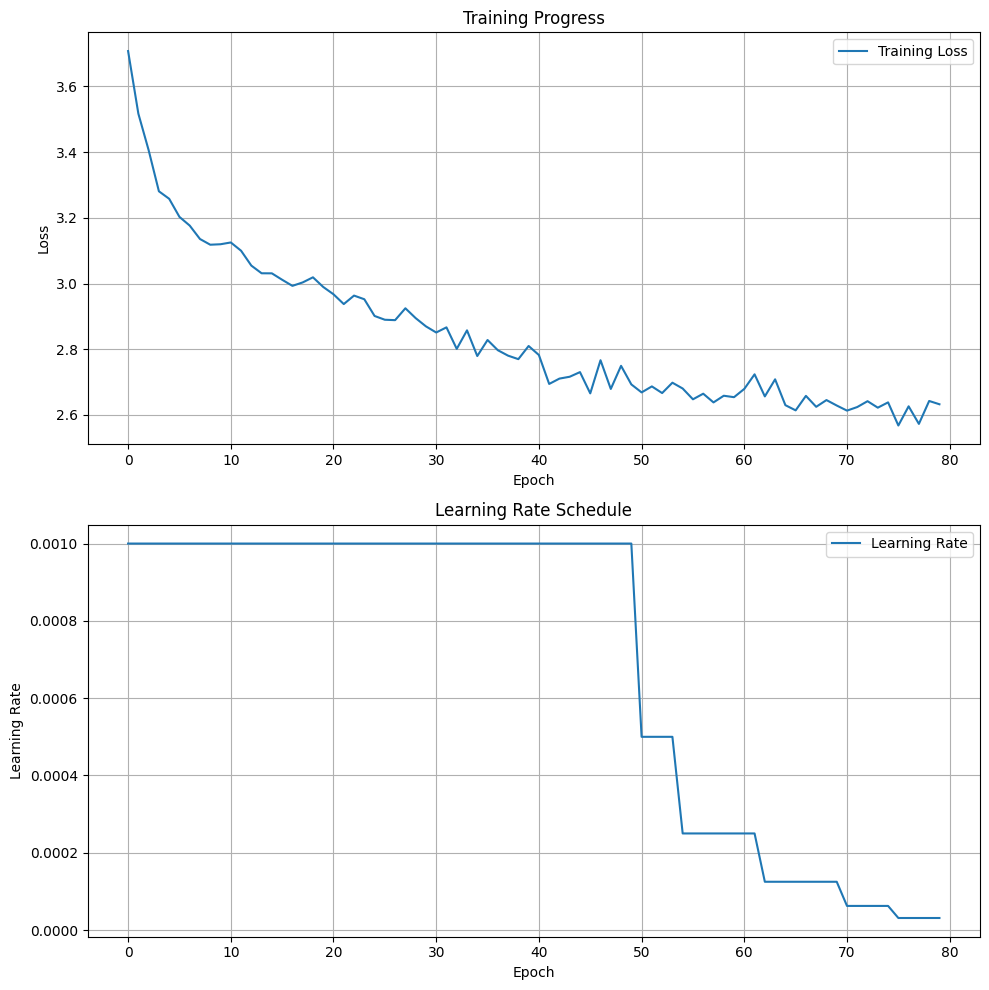

Current epoch: 80
Best loss: 2.5676
Current loss: 2.6323
Current learning rate: 0.000031
Epoch 80/100, Loss: 2.6323, LR: 0.000031


Epoch 81/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.6, lr=0.000016]


Epoch 81/100, Loss: 2.6506, LR: 0.000016


Epoch 82/100: 100%|██████████| 25/25 [00:55<00:00,  2.20s/it, loss=2.57, lr=0.000016]


Epoch 82/100, Loss: 2.6320, LR: 0.000016


Epoch 83/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, loss=2.52, lr=0.000016]


Epoch 83/100, Loss: 2.6330, LR: 0.000016


Epoch 84/100: 100%|██████████| 25/25 [00:56<00:00,  2.25s/it, loss=2.68, lr=0.000016]


Epoch 84/100, Loss: 2.6540, LR: 0.000016


Epoch 85/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, loss=2.58, lr=0.000008]


Epoch 85/100, Loss: 2.6454, LR: 0.000008


Epoch 86/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, loss=2.6, lr=0.000008]


Epoch 86/100, Loss: 2.6447, LR: 0.000008


Epoch 87/100: 100%|██████████| 25/25 [00:54<00:00,  2.17s/it, loss=2.78, lr=0.000008]


Epoch 87/100, Loss: 2.6262, LR: 0.000008


Epoch 88/100: 100%|██████████| 25/25 [00:54<00:00,  2.20s/it, loss=2.95, lr=0.000008]


Epoch 88/100, Loss: 2.6287, LR: 0.000008


Epoch 89/100: 100%|██████████| 25/25 [00:56<00:00,  2.26s/it, loss=2.68, lr=0.000004]


Epoch 89/100, Loss: 2.6294, LR: 0.000004


Epoch 90/100: 100%|██████████| 25/25 [00:56<00:00,  2.26s/it, loss=2.77, lr=0.000004]


Epoch 90/100, Loss: 2.6375, LR: 0.000004


Epoch 91/100: 100%|██████████| 25/25 [00:57<00:00,  2.29s/it, loss=2.53, lr=0.000004]


Epoch 91/100, Loss: 2.6285, LR: 0.000004


Epoch 92/100: 100%|██████████| 25/25 [00:54<00:00,  2.20s/it, loss=2.47, lr=0.000004]


Epoch 92/100, Loss: 2.6246, LR: 0.000004


Epoch 93/100: 100%|██████████| 25/25 [00:56<00:00,  2.28s/it, loss=2.66, lr=0.000002]


Epoch 93/100, Loss: 2.5950, LR: 0.000002


Epoch 94/100: 100%|██████████| 25/25 [00:55<00:00,  2.20s/it, loss=2.54, lr=0.000002]


Epoch 94/100, Loss: 2.6008, LR: 0.000002


Epoch 95/100: 100%|██████████| 25/25 [00:56<00:00,  2.28s/it, loss=2.79, lr=0.000002]


Epoch 95/100, Loss: 2.6104, LR: 0.000002


Epoch 96/100: 100%|██████████| 25/25 [00:57<00:00,  2.30s/it, loss=2.79, lr=0.000002]


Epoch 96/100, Loss: 2.6475, LR: 0.000002


Epoch 97/100: 100%|██████████| 25/25 [00:58<00:00,  2.35s/it, loss=2.82, lr=0.000001]


Epoch 97/100, Loss: 2.6129, LR: 0.000001


Epoch 98/100: 100%|██████████| 25/25 [00:56<00:00,  2.26s/it, loss=2.87, lr=0.000001]


Epoch 98/100, Loss: 2.6663, LR: 0.000001


Epoch 99/100: 100%|██████████| 25/25 [00:54<00:00,  2.19s/it, loss=2.35, lr=0.000001]


Epoch 99/100, Loss: 2.6307, LR: 0.000001


Epoch 100/100: 100%|██████████| 25/25 [00:55<00:00,  2.24s/it, loss=2.7, lr=0.000001]


Validation Dice score: 0.0635
Saved new best model with Dice score: 0.0635


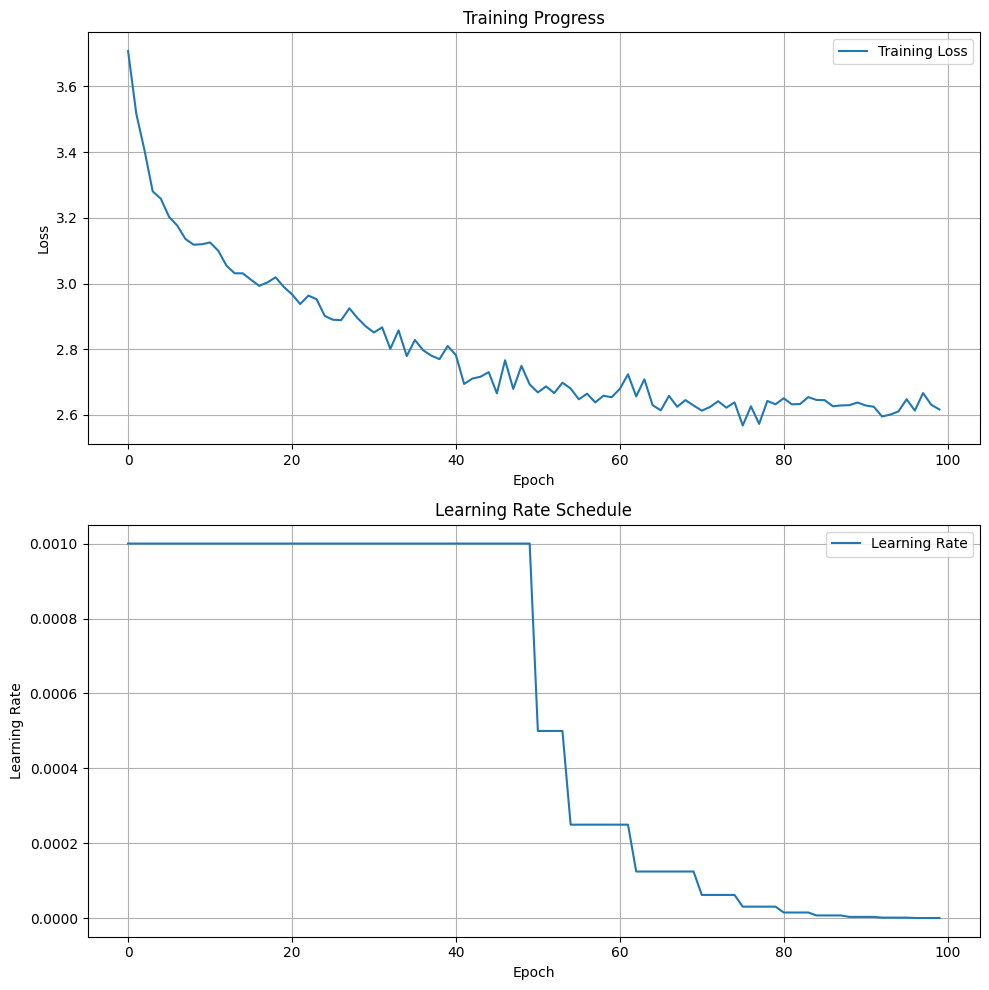

Current epoch: 100
Best loss: 2.5676
Current loss: 2.6164
Current learning rate: 0.000001
Epoch 100/100, Loss: 2.6164, LR: 0.000001
==== 验证集评估指标 ===
请先pip install medpy
请先pip install medpy
Val Dice: [np.float64(0.529806028199336), np.float64(6.302289306580689e-05), nan, np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.6613479171682888), np.float64(0.0001360914534562599), np.float64(0.0), np.float64(0.0), nan, np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.7143991953035547), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), nan, np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], Mean Dice: 0.0706
IoU: [np.float64(0.3603647126579088), np.float64(3.151243953545699e-05), nan, np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.49404018090294954

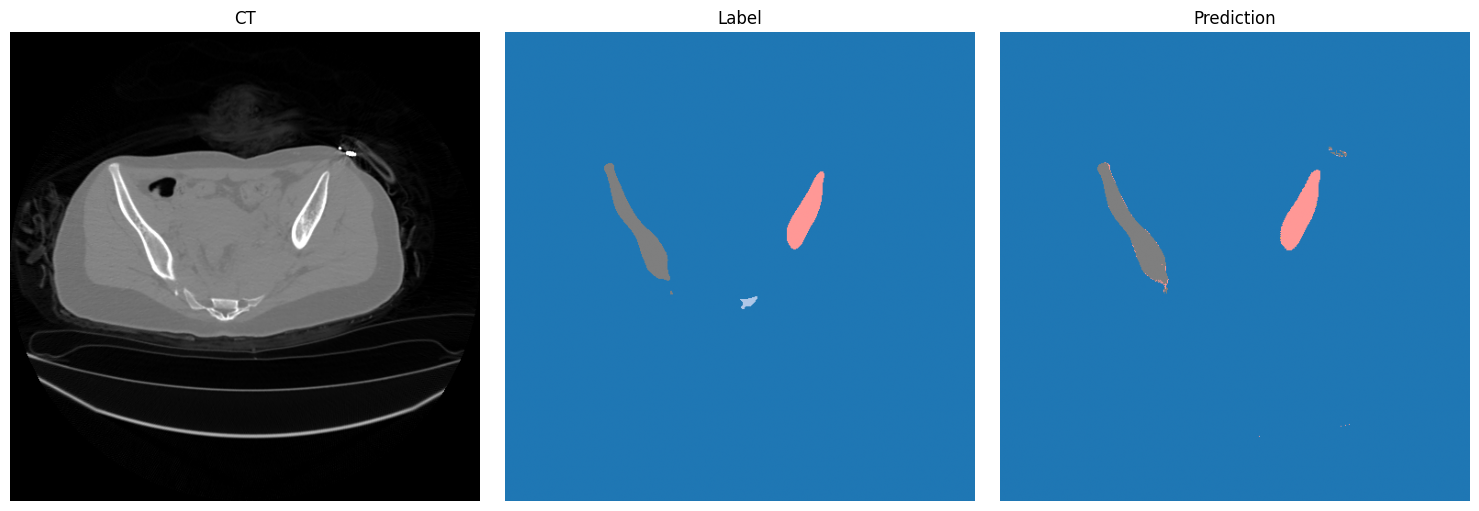

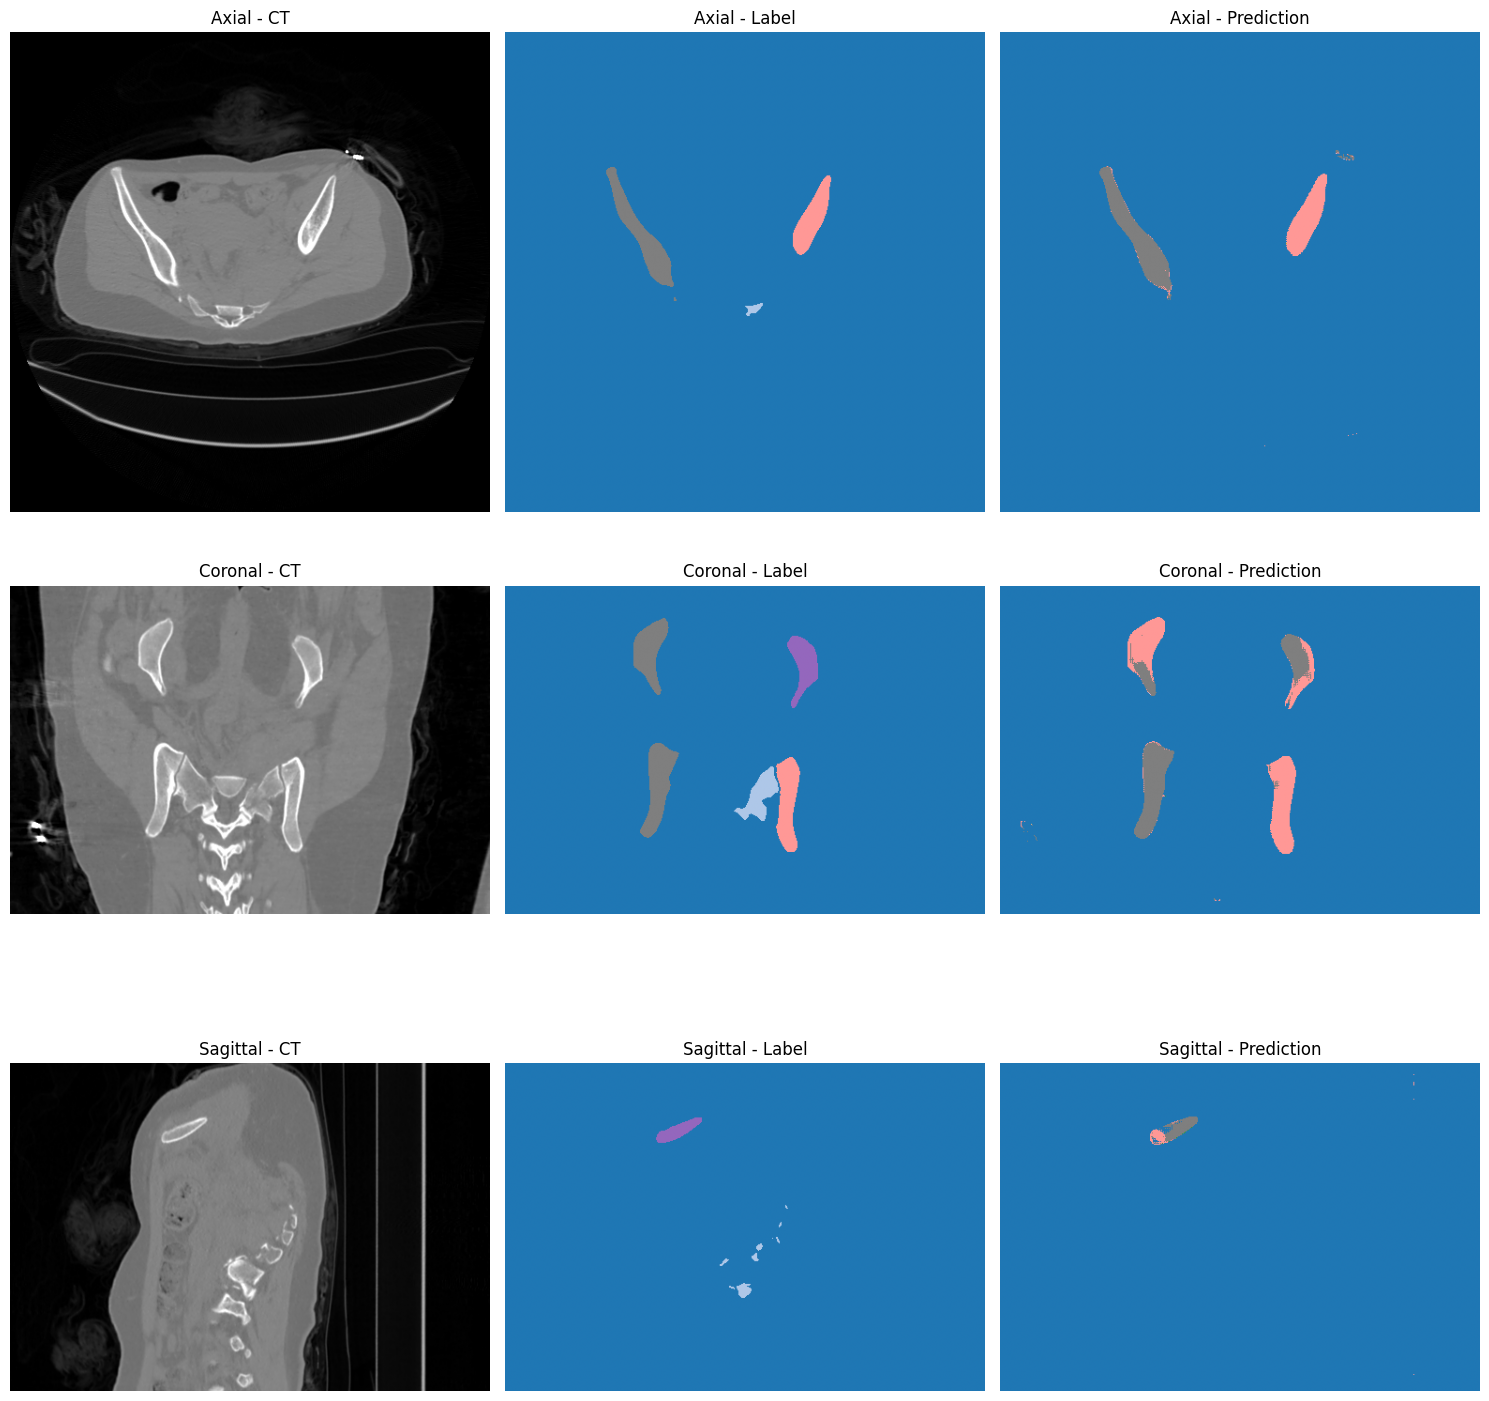

验证集平均Dice: 0.0706, 平均IoU: 0.0522, 平均HD95: nan, 平均ASSD: nan


<ipython-input-6-43e79fd1a037>:465: RuntimeWarning: Mean of empty slice
  print(f'验证集平均Dice: {np.nanmean(all_dices):.4f}, 平均IoU: {np.nanmean(all_ious):.4f}, 平均HD95: {np.nanmean(all_hd95s):.4f}, 平均ASSD: {np.nanmean(all_assds):.4f}')


In [ ]:
# Dataset and DataLoader setup
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
    transforms.Normalize((0.5,), (0.5,))
])

class CTScanDataset(Dataset):
    def __init__(self, images_path, labels_path, patch_size=(128, 128, 128), stride=(26, 26, 26)):
        self.image_paths = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.mha')])
        self.label_paths = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.mha')])
        self.patch_size = patch_size
        self.stride = stride
        self.num_classes = 31  # 0=background, 1-10=sacrum, 11-20=left hip, 21-30=right hip

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and label
        image = sitk.GetArrayFromImage(sitk.ReadImage(self.image_paths[idx])).astype(np.float32)
        label = sitk.GetArrayFromImage(sitk.ReadImage(self.label_paths[idx])).astype(np.int64)  # Change to int64 for labels

        # Preprocessing
        image = np.clip(image, -1000, 1000)
        image = (image + 1000) / 2000

        # No need to binarize labels anymore, keep original values (0-30)
        label = np.clip(label, 0, self.num_classes - 1)  # Ensure labels are in valid range

        # Extract random patch
        D, H, W = image.shape
        d = np.random.randint(0, max(1, D - self.patch_size[0] + 1))
        h = np.random.randint(0, max(1, H - self.patch_size[1] + 1))
        w = np.random.randint(0, max(1, W - self.patch_size[2] + 1))

        image_patch = image[d:d+self.patch_size[0], h:h+self.patch_size[1], w:w+self.patch_size[2]]
        label_patch = label[d:d+self.patch_size[0], h:h+self.patch_size[1], w:w+self.patch_size[2]]

        # Add channel dimension for image only
        image_patch = np.expand_dims(image_patch, axis=0)

        return torch.tensor(image_patch), torch.tensor(label_patch)

# Initialize dataset with patch-based approach
train_dataset = CTScanDataset(
    images_path=images_path,
    labels_path=labels_path,
    patch_size=PATCH_SIZE,
    stride=STRIDE
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,  # Keep memory optimizations
    num_workers=2     # Keep parallel loading
)

# Model initialization
NUM_CLASSES = 31  # 0=background, 1-10=sacrum, 11-20=left hip, 21-30=right hip
model = UNet3D(in_channels=1, out_channels=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
# 切换为ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

class TrainingMonitor:
    def __init__(self):
        self.train_losses = []
        self.learning_rates = []
        self.current_epoch = 0

    def update(self, epoch_loss, learning_rate):
        self.train_losses.append(epoch_loss)
        self.learning_rates.append(learning_rate)
        self.current_epoch += 1

    def plot_progress(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Plot loss
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.set_title('Training Progress')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        ax1.legend()

        # Plot learning rate
        ax2.plot(self.learning_rates, label='Learning Rate')
        ax2.set_title('Learning Rate Schedule')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Learning Rate')
        ax2.grid(True)
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def print_stats(self):
        print(f"Current epoch: {self.current_epoch}")
        print(f"Best loss: {min(self.train_losses):.4f}")
        print(f"Current loss: {self.train_losses[-1]:.4f}")
        print(f"Current learning rate: {self.learning_rates[-1]:.6f}")

# Initialize training monitor
monitor = TrainingMonitor()

# Update save paths at the start
best_model_dice_path = os.path.join(PATHS['models'], 'best_model_dice.pth')
best_model_loss_path = os.path.join(PATHS['models'], 'best_model_loss.pth')

def get_fragment_color(label):
    """
    Returns normalized color for different fragment types
    """
    if label == 0:  # Background
        return [0, 0, 0]
    elif 1 <= label <= 10:  # Sacrum fragments
        intensity = min(1.0, 0.3 + (label - 1) * 0.07)
        return [intensity, 0, 0]
    elif 11 <= label <= 20:  # Left hip fragments
        intensity = min(1.0, 0.3 + (label - 11) * 0.07)
        return [0, intensity, 0]
    elif 21 <= label <= 30:  # Right hip fragments
        intensity = min(1.0, 0.3 + (label - 21) * 0.07)
        return [0, 0, intensity]
    return [0, 0, 0]

def validate(model, val_image_path, val_label_path, patch_size=(128, 128, 128)):
    """
    Validate model performance on a single validation image
    Returns mean Dice score across all classes
    """
    model.eval()
    device = next(model.parameters()).device

    # Load validation image and label
    val_image = sitk.GetArrayFromImage(sitk.ReadImage(val_image_path)).astype(np.float32)
    val_label = sitk.GetArrayFromImage(sitk.ReadImage(val_label_path)).astype(np.int64)

    # Preprocess
    val_image = np.clip(val_image, -1000, 1000)
    val_image = (val_image + 1000) / 2000
    val_label = np.clip(val_label, 0, NUM_CLASSES - 1)

    # Predict using sliding window
    prediction = predict_volume(model, val_image, patch_size=patch_size)

    # Calculate Dice score for each class
    dice_scores = []
    for class_idx in range(1, NUM_CLASSES):  # Skip background class
        pred_class = (prediction == class_idx).astype(np.float32)
        true_class = (val_label == class_idx).astype(np.float32)

        intersection = np.sum(pred_class * true_class)
        dice_score = (2. * intersection) / (np.sum(pred_class) + np.sum(true_class) + 1e-7)
        dice_scores.append(dice_score)

    return np.mean(dice_scores)

def predict_volume(model, image, patch_size=(128, 128, 128), stride=(26, 26, 26)):
    """Predict segmentation using sliding window approach"""
    model.eval()
    device = next(model.parameters()).device

    D, H, W = image.shape
    output = np.zeros((NUM_CLASSES, D, H, W), dtype=np.float32)
    weight = np.zeros((NUM_CLASSES, D, H, W), dtype=np.float32)

    # Calculate steps
    d_steps = range(0, D - patch_size[0] + 1, stride[0])
    h_steps = range(0, H - patch_size[1] + 1, stride[1])
    w_steps = range(0, W - patch_size[2] + 1, stride[2])

    # Handle edge cases
    if D < patch_size[0]:
        d_steps = [0]
    if H < patch_size[1]:
        h_steps = [0]
    if W < patch_size[2]:
        w_steps = [0]

    with torch.no_grad():
        for d in d_steps:
            for h in h_steps:
                for w in w_steps:
                    # Extract patch
                    d_end = min(d + patch_size[0], D)
                    h_end = min(h + patch_size[1], H)
                    w_end = min(w + patch_size[2], W)

                    patch = image[d:d_end, h:h_end, w:w_end]

                    # Initialize padding values before potential assignment
                    pad_d, pad_h, pad_w = 0, 0, 0

                    # Pad if necessary
                    if patch.shape != patch_size:
                        pad_d = patch_size[0] - patch.shape[0]
                        pad_h = patch_size[1] - patch.shape[1]
                        pad_w = patch_size[2] - patch.shape[2]

                        patch = np.pad(patch,
                                     ((0, pad_d), (0, pad_h), (0, pad_w)),
                                     mode='constant')

                    # Predict
                    patch = torch.tensor(patch).float().unsqueeze(0).unsqueeze(0).to(device)
                    with torch.amp.autocast('cuda'):
                        pred = model(patch)
                        pred = torch.softmax(pred, dim=1).cpu().numpy()[0]  # Apply softmax for probabilities

                    # Unpad if necessary
                    if pad_d > 0 or pad_h > 0 or pad_w > 0:
                        pred = pred[:, :d_end-d, :h_end-h, :w_end-w]

                    # Add to output with weight
                    output[:, d:d_end, h:h_end, w:w_end] += pred
                    weight[:, d:d_end, h:h_end, w:w_end] += 1

    # Average overlapping predictions
    output = np.divide(output, weight, where=weight!=0)

    # Get final class predictions
    final_prediction = np.argmax(output, axis=0)
    return final_prediction

def visualize_prediction(prediction):
    """
    Convert prediction to RGB image for visualization
    """
    D, H, W = prediction.shape
    rgb_image = np.zeros((D, H, W, 3), dtype=np.float32)

    for label in range(NUM_CLASSES):
        mask = prediction == label
        color = get_fragment_color(label)
        for c in range(3):
            rgb_image[mask, c] = color[c]

    return rgb_image

def convert_weights(checkpoint_dict, num_classes):
    """
    Convert weights from binary classification to multi-class classification
    Only converts the final layer weights, keeps other layers unchanged
    """
    new_state_dict = checkpoint_dict['model_state_dict']

    # Get the old output layer weights
    old_output_weight = new_state_dict['output.0.weight']  # Shape: [1, 64, 1, 1, 1]
    old_output_bias = new_state_dict['output.0.bias']      # Shape: [1]

    # Create new output layer weights
    new_output_weight = torch.zeros((num_classes, 64, 1, 1, 1), device=old_output_weight.device)
    new_output_bias = torch.zeros(num_classes, device=old_output_bias.device)

    # Initialize with old weights (for the first class)
    new_output_weight[0] = old_output_weight[0]
    new_output_bias[0] = old_output_bias[0]

    # Random initialize other classes (optional)
    if num_classes > 1:
        nn.init.xavier_uniform_(new_output_weight[1:])
        nn.init.zeros_(new_output_bias[1:])

    # Update the state dict
    new_state_dict['output.0.weight'] = new_output_weight
    new_state_dict['output.0.bias'] = new_output_bias

    # Initialize BatchNorm parameters for multi-class
    new_state_dict['output.1.weight'] = torch.ones(num_classes)
    new_state_dict['output.1.bias'] = torch.zeros(num_classes)
    new_state_dict['output.1.running_mean'] = torch.zeros(num_classes)
    new_state_dict['output.1.running_var'] = torch.ones(num_classes)

    checkpoint_dict['model_state_dict'] = new_state_dict
    return checkpoint_dict

def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and optimizer state from checkpoint
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, weights_only=False)

    # Convert weights if necessary
    if 'model_state_dict' in checkpoint:
        output_shape = checkpoint['model_state_dict']['output.0.weight'].shape
        if output_shape[0] != NUM_CLASSES:
            print(f"Converting weights from {output_shape[0]} classes to {NUM_CLASSES} classes...")
            checkpoint = convert_weights(checkpoint, NUM_CLASSES)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    start_epoch = checkpoint['epoch'] + 1

    # 重新计算remaining_epochs并创建新的scheduler
    remaining_epochs = NUM_EPOCHS - start_epoch
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True
    )

    # 如果checkpoint中包含scheduler状态，则恢复它
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    best_loss = checkpoint['loss'] if 'loss' in checkpoint else float('inf')
    best_dice = checkpoint['best_dice'] if 'best_dice' in checkpoint else 0

    print(f"Resuming from epoch {start_epoch}")
    print(f"Best loss so far: {best_loss:.4f}")
    if 'best_dice' in checkpoint:
        print(f"Best dice score so far: {best_dice:.4f}")

    return start_epoch, best_loss, best_dice, scheduler

def train_model(model, train_loader, val_image_path, val_label_path, criterion, optimizer,
                num_epochs, device, monitor, resume_from=None):
    best_loss = float('inf')
    best_dice = 0
    start_epoch = 0
    # scheduler 已在外部初始化
    scaler = torch.amp.GradScaler('cuda')
    total_steps = len(train_loader) * num_epochs
    current_step = 0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (images, masks) in enumerate(pbar):
            torch.cuda.empty_cache()

            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss = loss / ACCUMULATION_STEPS

            scaler.scale(loss).backward()

            if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                torch.cuda.empty_cache()
                current_step += 1

            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({
                'loss': loss.item() * ACCUMULATION_STEPS,
                'lr': f'{current_lr:.6f}'
            })

            running_loss += loss.item() * ACCUMULATION_STEPS
            del images, masks, outputs
            torch.cuda.empty_cache()

        avg_loss = running_loss / len(train_loader)
        current_lr = optimizer.param_groups[0]['lr']

        monitor.update(avg_loss, current_lr)
        # 在每个epoch结束后用avg_loss调整学习率
        scheduler.step(avg_loss)

        if (epoch + 1) % 50 == 0:  # 改为每20个epoch验证一次
            torch.cuda.empty_cache()
            model.eval()
            val_dice_score = validate(model, val_image_path, val_label_path, patch_size=PATCH_SIZE)
            print(f"Validation Dice score: {val_dice_score:.4f}")
            model.train()

            if val_dice_score > best_dice:
                best_dice = val_dice_score
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'dice_score': val_dice_score,
                }, best_model_dice_path)
                print(f"Saved new best model with Dice score: {val_dice_score:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_loss,
            }, best_model_loss_path)
            print(f"Saved new best model with loss: {best_loss:.4f}")

        # 每20个epoch保存检查点
        if (epoch + 1) % 20 == 0:  # 同样改为每20个epoch
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1:03d}.pth')
            torch.save({
                'epoch': epoch,
                'loss': avg_loss,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'dice_score': val_dice_score if 'dice_score' in locals() else None,
                'best_dice': best_dice,
                'best_loss': best_loss
            }, checkpoint_path)

            monitor.plot_progress()
            monitor.print_stats()

        torch.cuda.empty_cache()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

    # 训练结束后对验证集进行评估
    print('==== 验证集评估指标 ===')
    model.eval()
    all_dices, all_ious, all_hd95s, all_assds = [], [], [], []
    image_list, label_list, pred_list = [], [], []
    for val_img_path, val_lbl_path in zip([val_image_path], [val_label_path]):  # 可扩展为多个验证样本
        val_image = sitk.GetArrayFromImage(sitk.ReadImage(val_img_path)).astype(np.float32)
        val_label = sitk.GetArrayFromImage(sitk.ReadImage(val_lbl_path)).astype(np.int64)
        val_image = np.clip(val_image, -1000, 1000)
        val_image = (val_image + 1000) / 2000
        val_label = np.clip(val_label, 0, NUM_CLASSES - 1)
        prediction = predict_volume(model, val_image, patch_size=PATCH_SIZE)
        dices, mean_dice = dice_score(prediction, val_label, num_classes=NUM_CLASSES)
        ious, mean_iou = iou_score(prediction, val_label, num_classes=NUM_CLASSES)
        hd95s, mean_hd95 = hd95(prediction, val_label, spacing=(1,1,1), num_classes=NUM_CLASSES)
        assds, mean_assd = assd(prediction, val_label, spacing=(1,1,1), num_classes=NUM_CLASSES)
        print(f'Val Dice: {dices}, Mean Dice: {mean_dice:.4f}')
        print(f'IoU: {ious}, Mean IoU: {mean_iou:.4f}')
        print(f'HD95: {hd95s}, Mean HD95: {mean_hd95:.4f}')
        print(f'ASSD: {assds}, Mean ASSD: {mean_assd:.4f}')
        all_dices.append(mean_dice)
        all_ious.append(mean_iou)
        all_hd95s.append(mean_hd95)
        all_assds.append(mean_assd)
        # 可视化单个切片
        plot_slice(val_image, val_label, prediction, num_classes=NUM_CLASSES)
        # 可视化三视图
        plot_three_views(val_image, val_label, prediction, num_classes=NUM_CLASSES)
        # 收集用于九宫格
        image_list.append(val_image)
        label_list.append(val_label)
        pred_list.append(prediction)
    print(f'验证集平均Dice: {np.nanmean(all_dices):.4f}, 平均IoU: {np.nanmean(all_ious):.4f}, 平均HD95: {np.nanmean(all_hd95s):.4f}, 平均ASSD: {np.nanmean(all_assds):.4f}')
    # 九宫格可视化（如果有3个样本）
    if len(image_list) == 3:
        plot_multi_sample_three_views(image_list, label_list, pred_list, num_classes=NUM_CLASSES)

# Split your data into training and validation sets
all_image_files = sorted(os.listdir(images_path))
all_label_files = sorted(os.listdir(labels_path))

# Use last image for validation
val_image_path = os.path.join(images_path, all_image_files[-1])
val_label_path = os.path.join(labels_path, all_label_files[-1])

# Start training
print("Starting fresh training for multi-class segmentation...")
print(f"Number of classes: {NUM_CLASSES} (0=background, 1-10=sacrum, 11-20=left hip, 21-30=right hip)")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Using device: {device}")

# 从头开始训练，不使用checkpoint
train_model(model, train_loader, val_image_path, val_label_path,
           criterion, optimizer, NUM_EPOCHS, device, monitor, resume_from=None)



## 4. Model Visualization

In [ ]:
# Update save paths at the start
best_model_dice_path = os.path.join(PATHS['models'], 'best_model_dice.pth')
best_model_loss_path = os.path.join(PATHS['models'], 'best_model_loss.pth')

# Split your data into training and validation sets
all_image_files = sorted(os.listdir(images_path))
all_label_files = sorted(os.listdir(labels_path))

# Use last image for validation
val_image_path = os.path.join(images_path, all_image_files[-1])
val_label_path = os.path.join(labels_path, all_label_files[-1])

NUM_CLASSES = 31

def predict_volume(model, image, patch_size=(128, 128, 128), stride=(26, 26, 26), device=None):
    """Predict segmentation using sliding window approach"""
    model.eval()
    if device is None:
        device = next(model.parameters()).device


    D, H, W = image.shape
    output = np.zeros((NUM_CLASSES, D, H, W), dtype=np.float32)
    weight = np.zeros((NUM_CLASSES, D, H, W), dtype=np.float32)

    # Calculate steps
    d_steps = range(0, D - patch_size[0] + 1, stride[0])
    h_steps = range(0, H - patch_size[1] + 1, stride[1])
    w_steps = range(0, W - patch_size[2] + 1, stride[2])

    # Handle edge cases
    if D < patch_size[0]:
        d_steps = [0]
    if H < patch_size[1]:
        h_steps = [0]
    if W < patch_size[2]:
        w_steps = [0]

    with torch.no_grad():
        for d in d_steps:
            for h in h_steps:
                for w in w_steps:
                    # Extract patch
                    d_end = min(d + patch_size[0], D)
                    h_end = min(h + patch_size[1], H)
                    w_end = min(w + patch_size[2], W)

                    patch = image[d:d_end, h:h_end, w:w_end]

                    # Initialize padding values before potential assignment
                    pad_d, pad_h, pad_w = 0, 0, 0

                    # Pad if necessary
                    if patch.shape != patch_size:
                        pad_d = patch_size[0] - patch.shape[0]
                        pad_h = patch_size[1] - patch.shape[1]
                        pad_w = patch_size[2] - patch.shape[2]

                        patch = np.pad(patch,
                                     ((0, pad_d), (0, pad_h), (0, pad_w)),
                                     mode='constant')

                    # Predict
                    patch_tensor = torch.tensor(patch).float().unsqueeze(0).unsqueeze(0).to(device)
                    with torch.amp.autocast(device.type if device.type == 'cuda' else 'cpu'):
                        pred = model(patch_tensor)
                        pred = torch.softmax(pred, dim=1).cpu().numpy()[0]  # Apply softmax for probabilities

                    # Unpad if necessary
                    if pad_d > 0 or pad_h > 0 or pad_w > 0:
                        pred = pred[:, :d_end-d, :h_end-h, :w_end-w]

                    # Add to output with weight
                    output[:, d:d_end, h:h_end, w:w_end] += pred
                    weight[:, d:d_end, h:h_end, w:w_end] += 1

    # Average overlapping predictions
    output = np.divide(output, weight, where=weight!=0)

    # Get final class predictions
    final_prediction = np.argmax(output, axis=0)
    return final_prediction


# Prediction and Visualization after training
def visualize_single_slice(image_path, label_path, model_path, save_dir, num_classes, slice_idx=None):
    import torch
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image = sitk.GetArrayFromImage(sitk.ReadImage(image_path)).astype(np.float32)
    label = sitk.GetArrayFromImage(sitk.ReadImage(label_path)).astype(np.int64)
    image_normalized = np.clip(image, -1000, 1000)
    image_normalized = (image_normalized + 1000) / 2000
    model = UNet3D(in_channels=1, out_channels=num_classes).to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    prediction = predict_volume(model, image_normalized, device=device)
    if slice_idx is None:
        slice_idx = image.shape[0] // 2
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(image[slice_idx], cmap='gray')
    plt.title('Original CT')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(label[slice_idx], cmap='tab20', vmin=0, vmax=num_classes-1)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(prediction[slice_idx], cmap='tab20', vmin=0, vmax=num_classes-1)
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(plt.cm.ScalarMappable(cmap='tab20', norm=plt.Normalize(vmin=0, vmax=num_classes-1)), ax=plt.gca())
    save_path = os.path.join(save_dir, f'slice_{slice_idx}_comparison.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Comparison saved to: {save_path}")
    return slice_idx

def calculate_class_weights(dataset):
    """计算每个类别的权重"""
    class_counts = torch.zeros(NUM_CLASSES)
    for _, label in dataset:
        for i in range(NUM_CLASSES):
            class_counts[i] += (label == i).sum()

    # 使用逆频率作为权重
    total_pixels = class_counts.sum()
    class_weights = total_pixels / (class_counts * NUM_CLASSES)
    # 将背景类的权重降低
    class_weights[0] *= 0.5
    return class_weights.to(device)

def visualize_comparison_three_views(image_path, label_path, model_path, save_dir, num_classes):
    import torch
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image = sitk.GetArrayFromImage(sitk.ReadImage(image_path)).astype(np.float32)
    label = sitk.GetArrayFromImage(sitk.ReadImage(label_path)).astype(np.int64)
    image_normalized = np.clip(image, -1000, 1000)
    image_normalized = (image_normalized + 1000) / 2000
    model = UNet3D(in_channels=1, out_channels=num_classes).to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    prediction = predict_volume(model, image_normalized, device=device)
    D, H, W = image.shape
    mid_d, mid_h, mid_w = D//2, H//2, W//2
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    views = ['Axial', 'Coronal', 'Sagittal']
    for i, (view, slice_idx) in enumerate(zip(views, [mid_d, mid_h, mid_w])):
        if view == 'Axial':
            img_slice = image[slice_idx]
            lbl_slice = label[slice_idx]
            pred_slice = prediction[slice_idx]
        elif view == 'Coronal':
            img_slice = image[:, slice_idx, :]
            lbl_slice = label[:, slice_idx, :]
            pred_slice = prediction[:, slice_idx, :]
        else:
            img_slice = image[:, :, slice_idx]
            lbl_slice = label[:, :, slice_idx]
            pred_slice = prediction[:, :, slice_idx]
        axes[i, 0].imshow(img_slice, cmap='gray')
        axes[i, 0].set_title(f'{view} View - Original')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(lbl_slice, cmap='tab20', vmin=0, vmax=num_classes-1)
        axes[i, 1].set_title(f'{view} View - Ground Truth')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(pred_slice, cmap='tab20', vmin=0, vmax=num_classes-1)
        axes[i, 2].set_title(f'{view} View - Prediction')
        axes[i, 2].axis('off')
    plt.tight_layout()
    save_path = os.path.join(save_dir, f'three_views_comparison.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Comparison saved to: {save_path}")

def visualize_three_views_prediction(image_path, model_path, save_dir, num_classes, title=None):
    import torch
    import os
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image = sitk.GetArrayFromImage(sitk.ReadImage(image_path)).astype(np.float32)
    image_normalized = np.clip(image, -1000, 1000)
    image_normalized = (image_normalized + 1000) / 2000
    model = UNet3D(in_channels=1, out_channels=num_classes).to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    prediction = predict_volume(model, image_normalized, device=device)
    D, H, W = prediction.shape
    mid_d, mid_h, mid_w = D // 2, H // 2, W // 2
    plt.figure(figsize=(18, 6))
    if title is not None:
        plt.suptitle(title, fontsize=16)
    else:
        plt.suptitle(f"Prediction using {os.path.basename(model_path)}", fontsize=16)
    plt.subplot(1, 3, 1)
    plt.imshow(prediction[:, :, mid_w], cmap='tab20', vmin=0, vmax=num_classes-1)
    plt.title('Sagittal View')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(prediction[:, mid_h, :], cmap='tab20', vmin=0, vmax=num_classes-1)
    plt.title('Coronal View')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(prediction[mid_d, :, :], cmap='tab20', vmin=0, vmax=num_classes-1)
    plt.title('Axial View')
    plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'three_views_prediction.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=200)
    plt.close()
    print(f"Three-view prediction saved to: {save_path}")
    return save_path

# 训练和评估结束后，分别对两个模型做可视化
model_paths = [best_model_dice_path, best_model_loss_path]
model_names = ['best_dice', 'best_loss']

for model_path, model_name in zip(model_paths, model_names):
    model_save_dir = os.path.join(PATHS['results'], 'predictions', model_name)
    os.makedirs(model_save_dir, exist_ok=True)
    # 单切片对比
    visualize_single_slice(
        image_path=val_image_path,
        label_path=val_label_path,
        model_path=model_path,
        save_dir=model_save_dir,
        num_classes=NUM_CLASSES,
        slice_idx=None
    )
    # 三视图对比
    visualize_comparison_three_views(
        image_path=val_image_path,
        label_path=val_label_path,
        model_path=model_path,
        save_dir=model_save_dir,
        num_classes=NUM_CLASSES
    )
    # 三视图预测
    visualize_three_views_prediction(
        image_path=val_image_path,
        model_path=model_path,
        save_dir=model_save_dir,
        num_classes=NUM_CLASSES,
        title=f"Prediction ({model_name})"
    )




Comparison saved to: /content/drive/MyDrive/ct_segmentation/results/predictions/best_dice/slice_175_comparison.png
Comparison saved to: /content/drive/MyDrive/ct_segmentation/results/predictions/best_dice/three_views_comparison.png
Three-view prediction saved to: /content/drive/MyDrive/ct_segmentation/results/predictions/best_dice/three_views_prediction.png
Comparison saved to: /content/drive/MyDrive/ct_segmentation/results/predictions/best_loss/slice_175_comparison.png
Comparison saved to: /content/drive/MyDrive/ct_segmentation/results/predictions/best_loss/three_views_comparison.png
Three-view prediction saved to: /content/drive/MyDrive/ct_segmentation/results/predictions/best_loss/three_views_prediction.png


CUDA memory clean up


In [ ]:
import torch
import gc

def cleanup_cuda():
    # Clear GPU cache
    torch.cuda.empty_cache()

    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()

    # Get current device
    device = torch.cuda.current_device()

    # Print memory stats before cleanup
    print("Memory stats before cleanup:")
    print(f"Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
    print(f"Cached: {torch.cuda.memory_reserved(device) / 1024**2:.2f} MB")

    # Clear all PyTorch tensors
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                del obj
            elif hasattr(obj, 'data') and torch.is_tensor(obj.data):
                del obj.data
        except:
            pass

    # Run garbage collector
    gc.collect()

    # Empty cache again
    torch.cuda.empty_cache()

    # Print memory stats after cleanup
    print("\nMemory stats after cleanup:")
    print(f"Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
    print(f"Cached: {torch.cuda.memory_reserved(device) / 1024**2:.2f} MB")
    print("\nCUDA memory cleaned!")

# Run the cleanup
cleanup_cuda()

Memory stats before cleanup:
Allocated: 18607.81 MB
Cached: 19952.00 MB


<ipython-input-14-9b6695d1e615>:24: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  elif hasattr(obj, 'data') and torch.is_tensor(obj.data):



Memory stats after cleanup:
Allocated: 293.14 MB
Cached: 2562.00 MB

CUDA memory cleaned!
